# Exploring the Yeast Gene-Expression Landscape

In the world of biological data, every row of numbers tells a story of complexity and uncertainty. Here, we explore **gene expression data** from the Yeast dataset. Our mission is to understand not only the structure of this dataset but also its imperfections: noisy labels, outliers, and data that refuses to be easily categorized. To do so, we will journey into the realm of **manifold visualization techniques**, specifically **t-SNE** and **Isomap**. Both are dimensionality reduction methods, but they whisper different truths about the data: one about local neighborhoods, the other about global geometry.

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE, Isomap
from sklearn.metrics import silhouette_score
from collections import Counter 

random_seed = 42
np.random.seed(random_seed)
import warnings
warnings.filterwarnings("ignore")

### Part A: Preprocessing and Initial Setup

In [3]:
data = pd.read_csv('yeast_dataset/yeast.csv')

X = data.iloc[:, 1:-14].values
Y = data.iloc[:, -14:].values

print("Shape of feature matrix X:", X.shape)
print("Shape of label matrix Y:", Y.shape)

Shape of feature matrix X: (2417, 103)
Shape of label matrix Y: (2417, 14)


- **X**: Feature matrix with `103` features of 2417 samples 
- **Y**: Binary matrix of `14` labels of 2417 samples

In [4]:
# Converting binary label matrix into string-based identifiers
label_strings = ["".join(map(str, row)) for row in Y]
label_counts = Counter(label_strings)

single_labels = [lbl for lbl in label_counts if lbl.count("1") == 1]
top_single = sorted(single_labels, key=lambda x: label_counts[x], reverse=True)

multi_labels = [lbl for lbl in label_counts if lbl.count("1") > 1]
top_multi = max(multi_labels, key=lambda x: label_counts[x]) if multi_labels else None

# Creating new categorical variable
def categorize_label(lbl):
    if len(top_single) >= 1 and lbl == top_single[0]:
        return "Class A"
    elif len(top_single) >= 2 and lbl == top_single[1]:
        return "Class B"
    elif top_multi is not None and lbl == top_multi:
        return "Multi-label Combo"
    else:
        return "Other"

categories = [categorize_label(lbl) for lbl in label_strings]

#### Simplifying Labels for Visualization:

With **14 labels** and thousands of possible combinations, a direct visualization would turn into a chaotic rainbow.  
So, we simplify:

- **Class A**: The most common single-label category  
- **Class B**: The second most common single-label category  
- **Multi-label Combo**: The most frequent multi-label combination  
- **Other**: Everything else  

This approach allows us to focus on the most meaningful contrasts without drowning in color noise.

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Before stepping into dimensionality reduction, scaling is crucial.  
Both **t-SNE** and **Isomap** rely on distances between points. Without scaling, features with large numeric ranges would dominate these distances, misleading the algorithm.  

Thus, we standardize the dataset so every feature has **zero mean** and **unit variance**, giving all features an equal voice.


### Part B: t-SNE and Veracity Inspection

Best Perplexity=30, Silhouette Score=-0.0573


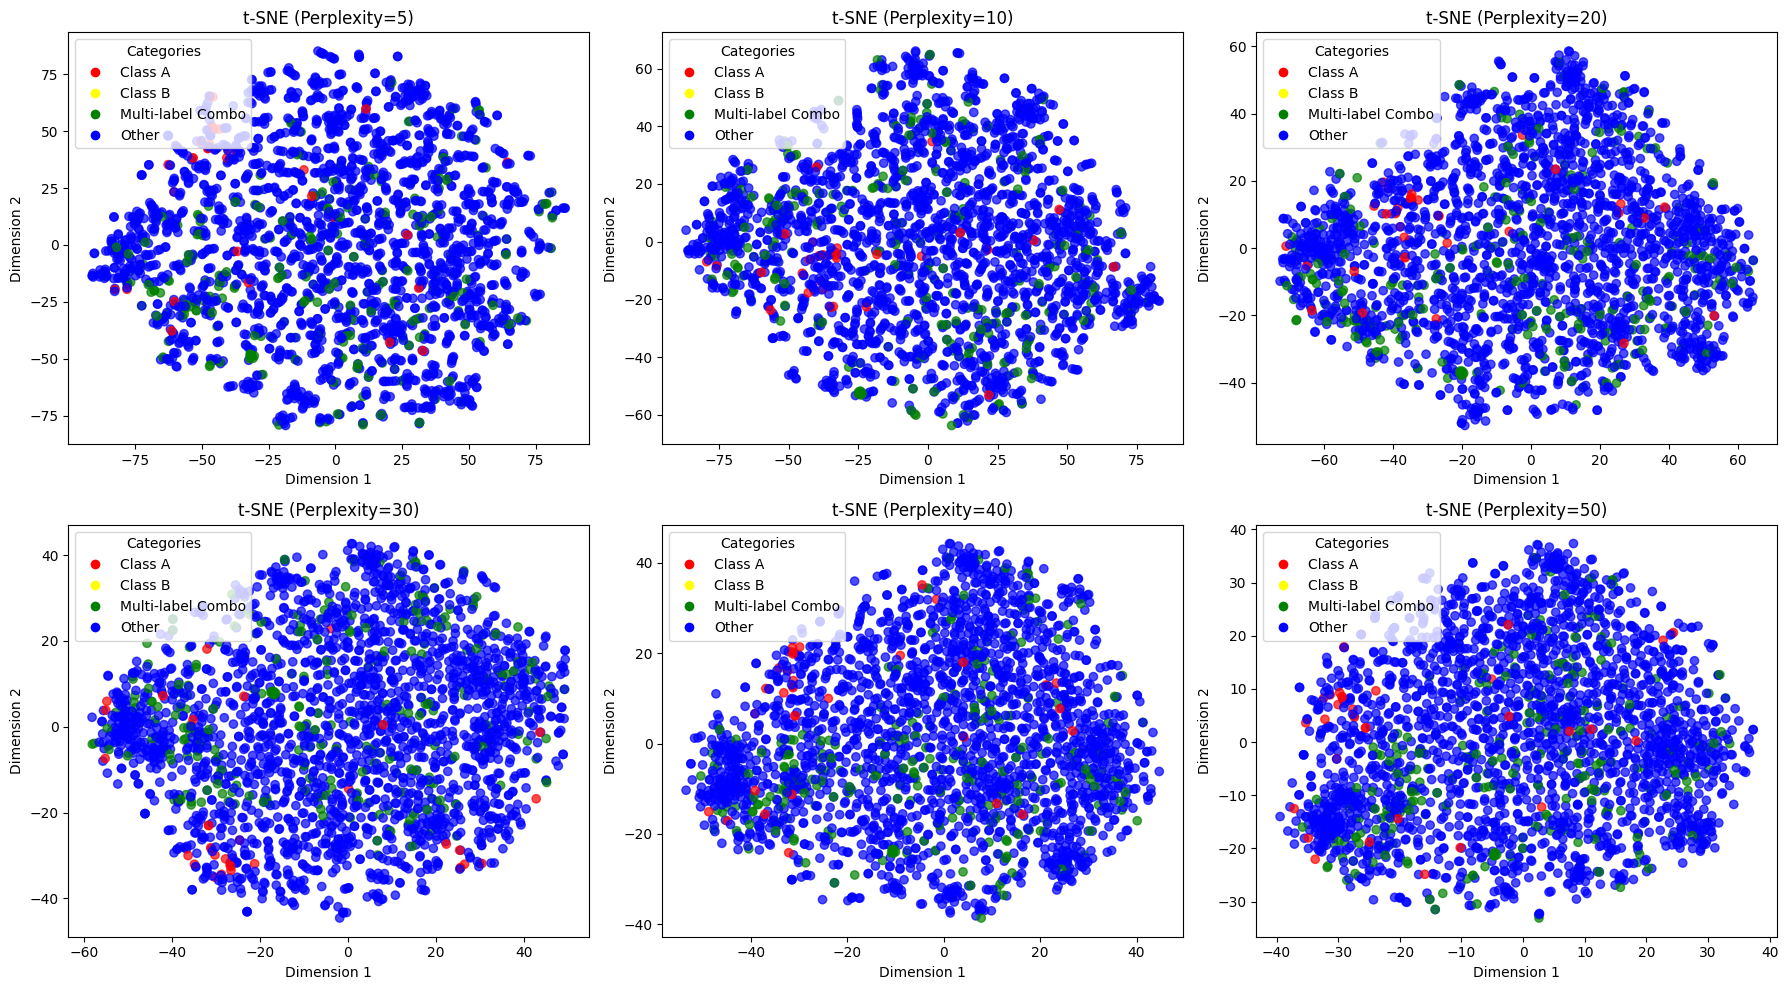

In [6]:
perplexities = [5, 10, 20, 30, 40, 50]
scores = []
tsne_results = {}

color_map = {"Class A": "red", "Class B": "yellow", "Multi-label Combo": "green", "Other": "blue"}
category_series = pd.Categorical(categories, categories=list(color_map.keys()))
colors = category_series.map(color_map)
unique_labels = list(color_map.keys())

for p in perplexities:
    tsne = TSNE(n_components=2, perplexity=p, random_state=42)
    X_embedded = tsne.fit_transform(X_scaled)
    tsne_results[p] = X_embedded
    score = silhouette_score(X_embedded, category_series.codes)
    scores.append((p, score))

best_p, best_score = max(scores, key=lambda x: x[1])
print(f"Best Perplexity={best_p}, Silhouette Score={best_score:.4f}")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
for i, p in enumerate(perplexities):
    scatter = axes[i].scatter(tsne_results[p][:,0], tsne_results[p][:,1],
                              c=category_series.map(color_map), alpha=0.7)
    axes[i].set_title(f"t-SNE (Perplexity={p})")
    
    handles = [plt.Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=color, markersize=8, label=label)
               for label, color in color_map.items()]
    axes[i].legend(handles=handles, title="Categories", loc="best")
    axes[i].set_xlabel("Dimension 1")
    axes[i].set_ylabel("Dimension 2")

plt.tight_layout()
plt.show()

#### **Preliminary Observation: Absence of a Class**
First, it is important to note that there are no yellow points corresponding to "Class B" visible in the plot. This indicates that either Class B (i.e) there is only one 'single class label' present in this dataset, which is "Class A". The analysis will proceed focusing on Class A (red), Multi-label Combo (green), and Other (blue).

#### Using Silhouette Score to choose Perplexity parameter:

We let **t-SNE** weave its magic, collapsing 103-dimensional gene expression data into 2 dimensions.  
The **perplexity parameter** can be thought of as a continuous measure of the number of effective nearest neighbors considered for each data point. Essentially, it controls how t-SNE balances local vs global structure.  

#### Understanding Silhouette Score:

The **Silhouette Score** is a metric that evaluates the quality of clustering. It measures how well each data point fits within its assigned cluster compared to other clusters.

For each point \(i\):

- **a(i):** The average distance to all other points in the **same cluster**. (Measures cluster compactness)  
- **b(i):** The minimum average distance to points in any **other cluster**. (Measures separation from the nearest neighboring cluster)  

The silhouette score for that point is defined as:

$$
s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
$$

#### Interpretation of the Score:
- \(s(i)\) ranges from **-1 to +1**.  
  - **+1** → The point is well-clustered, far from neighboring clusters.  
  - **0** → The point is on the border between clusters.  
  - **Negative** → The point may be assigned to the wrong cluster, as it is closer to another cluster.  

The overall silhouette score is the average of all \(s(i)\) across the dataset.

In the context of **t-SNE**, which is not primarily a clustering algorithm but a **visualization tool**, silhouette scores are often **negative or close to zero**, as the main goal of t-SNE is to reveal structure for human inspection, not to maximize clustering metrics.  

Among the tested values, perplexity = 30 gave the *least negative* silhouette score, indicating the **best relative separation**.

#### Visual Interpretation:
The goal of t-SNE is to create a low-dimensional map that reveals the underlying structure of high-dimensional data. A "good" visualization should ideally group similar data points into distinct clusters while also preserving some of the larger, global structure.

A value that is too low (5) fails to form meaningful groups, while a value that is too high (40-50) merges distinct groups. The Perplexity=20 and 30 plots provide the most insightful visualization by clearly separating the minority classes (Class A and Multi-label Combo) into discernible clusters while maintaining a coherent overall structure.
This matches what we observed visually, perplexity around 30 usually provides a reasonable balance between local and global structure in t-SNE.

Therefore, we choose the `perplexity = 30` as our final choice according to the above discussions.


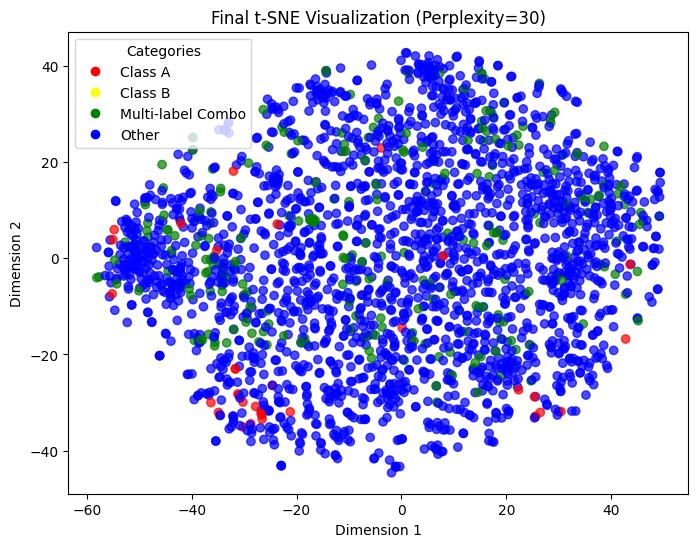

In [ ]:
tsne_final = TSNE(n_components=2, perplexity=best_p, random_state=random_seed)
X_tsne_final = tsne_final.fit_transform(X_scaled)

color_map = {"Class A": "red", "Class B": "yellow", "Multi-label Combo": "green", "Other": "blue"}
category_series = pd.Categorical(categories, categories=list(color_map.keys()))
colors = category_series.map(color_map)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_tsne_final[:, 0], X_tsne_final[:, 1], c=colors, alpha=0.7)
handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=8)
           for label, color in color_map.items()]
plt.legend(handles=handles, title="Categories", loc="best")

plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title(f't-SNE Visualization (Perplexity={best_p})')
plt.show()

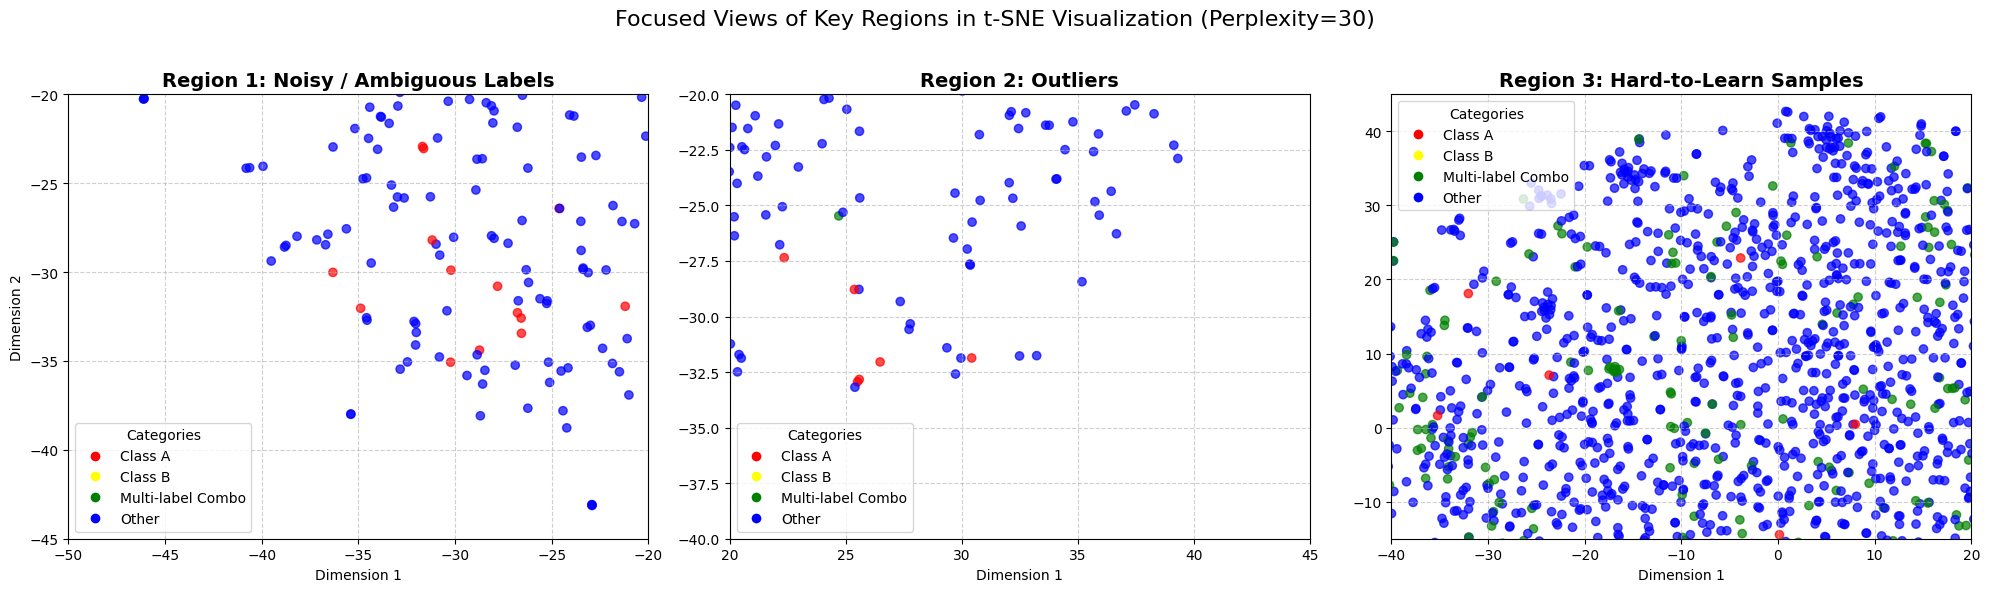

In [15]:
tsne_final = TSNE(n_components=2, perplexity=best_p, random_state=random_seed)
X_tsne_final = tsne_final.fit_transform(X_scaled)

color_map = {"Class A": "red", "Class B": "yellow", "Multi-label Combo": "green", "Other": "blue"}
category_series = pd.Categorical(categories, categories=list(color_map.keys()))
colors = category_series.map(color_map)


handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=8)
           for label, color in color_map.items()]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Subplot 1: Noisy/Ambiguous Labels
ax1.scatter(X_tsne_final[:, 0], X_tsne_final[:, 1], c=colors, alpha=0.7)
ax1.set_title("Region 1: Noisy / Ambiguous Labels", fontsize=14, weight='bold')
ax1.set_xlabel("Dimension 1")
ax1.set_ylabel("Dimension 2")
# Plot limits to zoom in on the lower-left cluster
ax1.set_xlim(-50, -20)
ax1.set_ylim(-45, -20)
ax1.legend(handles=handles, title="Categories")
ax1.grid(True, linestyle='--', alpha=0.6)

# Subplot 2: Outliers 
ax2.scatter(X_tsne_final[:, 0], X_tsne_final[:, 1], c=colors, alpha=0.7)
ax2.set_title("Region 2: Outliers", fontsize=14, weight='bold')
ax2.set_xlabel("Dimension 1")
# Plot limits to zoom in on the small, isolated bottom-right cluster
ax2.set_xlim(20, 45)
ax2.set_ylim(-40, -20)
ax2.legend(handles=handles, title="Categories")
ax2.grid(True, linestyle='--', alpha=0.6)

# Subplot 3: Hard-to-Learn Samples
ax3.scatter(X_tsne_final[:, 0], X_tsne_final[:, 1], c=colors, alpha=0.7)
ax3.set_title("Region 3: Hard-to-Learn Samples", fontsize=14, weight='bold')
ax3.set_xlabel("Dimension 1")
# Plot limits to zoom in on the mixed central/upper area
ax3.set_xlim(-40, 20)
ax3.set_ylim(-15, 45)
ax3.legend(handles=handles, title="Categories")
ax3.grid(True, linestyle='--', alpha=0.6)

fig.suptitle(f"Focused Views of Key Regions in t-SNE Visualization (Perplexity={best_p})", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

#### Analysis of the t-SNE Visualization (Perplexity=30)

#####  Noisy/Ambiguous Labels

These are points whose labels seem inconsistent with their neighbors in the feature space.

*   **Region of Interest:** The primary cluster of **Class A (red)** in the lower-left quadrant (approx. Dimension 1: -50 to -20, Dimension 2: -40 to -20).

*   **Visual Identification:** Within this dense red cluster, there are a **blue ("Other") points** deeply embedded.

*   **Interpretation:** A blue point that lands squarely in the middle of a red cluster suggests that its underlying features are extremely similar to Class A samples. This could be due to:
    1.  **A Mislabeled Sample:** It might truly belong to Class A but was incorrectly labeled as "Other".
    2.  **An Ambiguous Sample:** It could be a transitional or boundary case that shares features with both classes.


##### Outliers

These are points or small groups that are distinct and far from the main data distribution.

*   **Region of Interest:** The peripheries of the main point cloud.

*   **Visual Identification:**
    1.  There is a small, tight cluster of 2-3 **red (Class A) points** at the far bottom-right (approx. Dimension 1: 25 to 35, Dimension 2: -35).
    2.  An even more isolated single **red (Class A) point** is visible on the far-right edge (approx. Dimension 1: 45, Dimension 2: -25).

*   **Hypothesis:** These unusual patterns could represent several possibilities:
    1.  **Rare Sub-types:** The small, distant cluster could represent a rare, but distinct, sub-category of Class A that has a unique feature profile.
    2.  **Data Entry or Measurement Error:** A single, very distant outlier could be the result of a technical artifact, contamination, or a significant error in data collection, causing its feature vector to be dramatically different from all other samples.
    3.  **Novel Discoveries:** In a biological context, such outliers might represent a previously unknown cell state, a response to a unique stimulus, or a rare mutation.


##### Hard-to-Learn Samples

These are areas where multiple classes are highly intermingled, making them difficult to separate.

*   **Region of Interest:** The large, central body of the plot, particularly the upper-left section (approx. Dimension 1: -40 to 10, Dimension 2: 0 to 40).

*   **Visual Identification:** In this region, **blue ("Other")**, **green ("Multi-label Combo")**, and some **red ("Class A")** points are thoroughly mixed. There are no clear boundaries or distinct clusters.

*   **Why a Simple Classifier Would Struggle:**
    *   **No Clear Seperation Boundary:** As we saw, primarily because of these "hard-to-learn" samples, there's no clear distinction for a point that lands in these spaces. 2-Dimensional t-SNE is not a sufficent dimensionality reduction method in this case.  
    *   **Feature Space Overlap:** The t-SNE visualization shows that in the original high-dimensional space, these samples are neighbors. This means their feature vectors are very similar, even though they belong to different classes.
    *   **Non-Linear Decision Boundary:** A simple classifier (like Logistic Regression or a Linear SVM) tries to find a simple plane to separate the classes. In this highly mixed region, no simple line can be drawn to cleanly separate green from blue or red. Any linear boundary would inevitably misclassify a large number of points, leading to poor performance (low precision and recall). A more complex, non-linear model would be required to even attempt to learn the intricate boundary between these classes.

### Part C: Isomap and Manifold Learning

#### Isomap vs. t-SNE: Global vs. Local Structure Preservation

The fundamental difference between Isomap and t-SNE lies in what aspect of the data's structure they prioritize preserving in the lower-dimensional space. Isomap focuses on preserving the **global geometric structure** of the data manifold, while t-SNE is optimized for visualizing the **local similarities** and cluster structures.

##### Isomap (Isometric Mapping)

Isomap is a manifold learning technique that aims to uncover and "unroll" the underlying low-dimensional geometry of the data.

*   **Primary Goal:** To preserve the **global geodesic distances** between all pairs of points. Geodesic distance is the shortest path between two points along the curved surface of the manifold, not a straight line through it.
*   **Core Mechanism:**
    1.  **Construct a Neighborhood Graph:** It first identifies the neighbors of each data point (using k-nearest neighbors or a radius) to approximate the local manifold structure.
    2.  **Calculate Geodesic Distances:** It computes the shortest path between all pairs of points by "walking" along the edges of the neighborhood graph (e.g., using Dijkstra's algorithm). This estimates the true geodesic distance.
    3.  **Apply Multidimensional Scaling (MDS):** It uses classical MDS on the matrix of geodesic distances to find a low-dimensional embedding where the straight-line (Euclidean) distances between points best match their geodesic distances from the previous step.
*   **What it Preserves:** **Global Structure.** The distances between faraway points in an Isomap plot are meaningful and are intended to reflect their "true" distance along the data manifold. It is excellent for understanding the overall shape and layout of your data.

##### t-SNE (t-Distributed Stochastic Neighbor Embedding)

t-SNE is a visualization technique designed specifically to reveal local structure, such as clusters.

*   **Primary Goal:** To preserve the **local similarities** between neighboring points. It models the probability that two points are neighbors in both the high-dimensional and low-dimensional space and tries to make these probabilities match.
*   **Core Mechanism:**
    1.  **Model High-Dimensional Similarities:** It converts the high-dimensional Euclidean distances between data points into conditional probabilities representing similarities. Nearby points have a high probability of being "picked" as neighbors.
    2.  **Model Low-Dimensional Similarities:** It creates a similar probability distribution for the points in the low-dimensional map, but it uses a heavy-tailed t-distribution. This is a key feature, as the heavy tails allow dissimilar points to be placed much farther apart, helping to form tight, well-separated clusters.
    3.  **Minimize Divergence:** It iteratively adjusts the positions of the points in the low-dimensional map to minimize the difference (Kullback-Leibler divergence) between the two probability distributions.
*   **What it Preserves:** **Local Structure.** t-SNE is exceptionally good at showing which points are near each other and grouping them into visually distinct clusters. However, the distances between well-separated clusters in a t-SNE plot are **not meaningful** and do not represent the true separation in the original space.

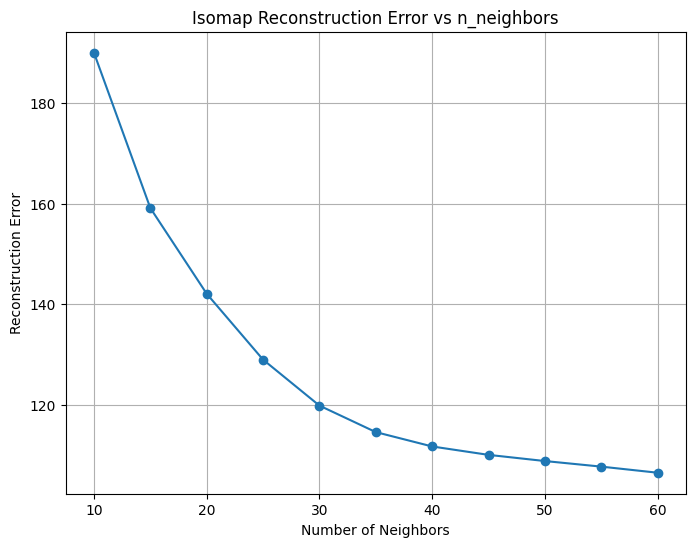

In [8]:
n_neighbors = list(range(10, 61, 5))
RecErrors = []
isomap_results = {}

for n in n_neighbors:
    iso = Isomap(n_components=2, n_neighbors=n)
    X_iso = iso.fit_transform(X_scaled)
    error = iso.reconstruction_error()
    RecErrors.append((n, error))

plt.figure(figsize=(8, 6))
plt.plot([x[0] for x in RecErrors], [x[1] for x in RecErrors], marker='o')
plt.title("Isomap Reconstruction Error vs n_neighbors")
plt.xlabel("Number of Neighbors")
plt.ylabel("Reconstruction Error")
plt.grid(True)
plt.show()

From the above plot, we observe that the **elbow** appears around `n_neighbours = 30`.

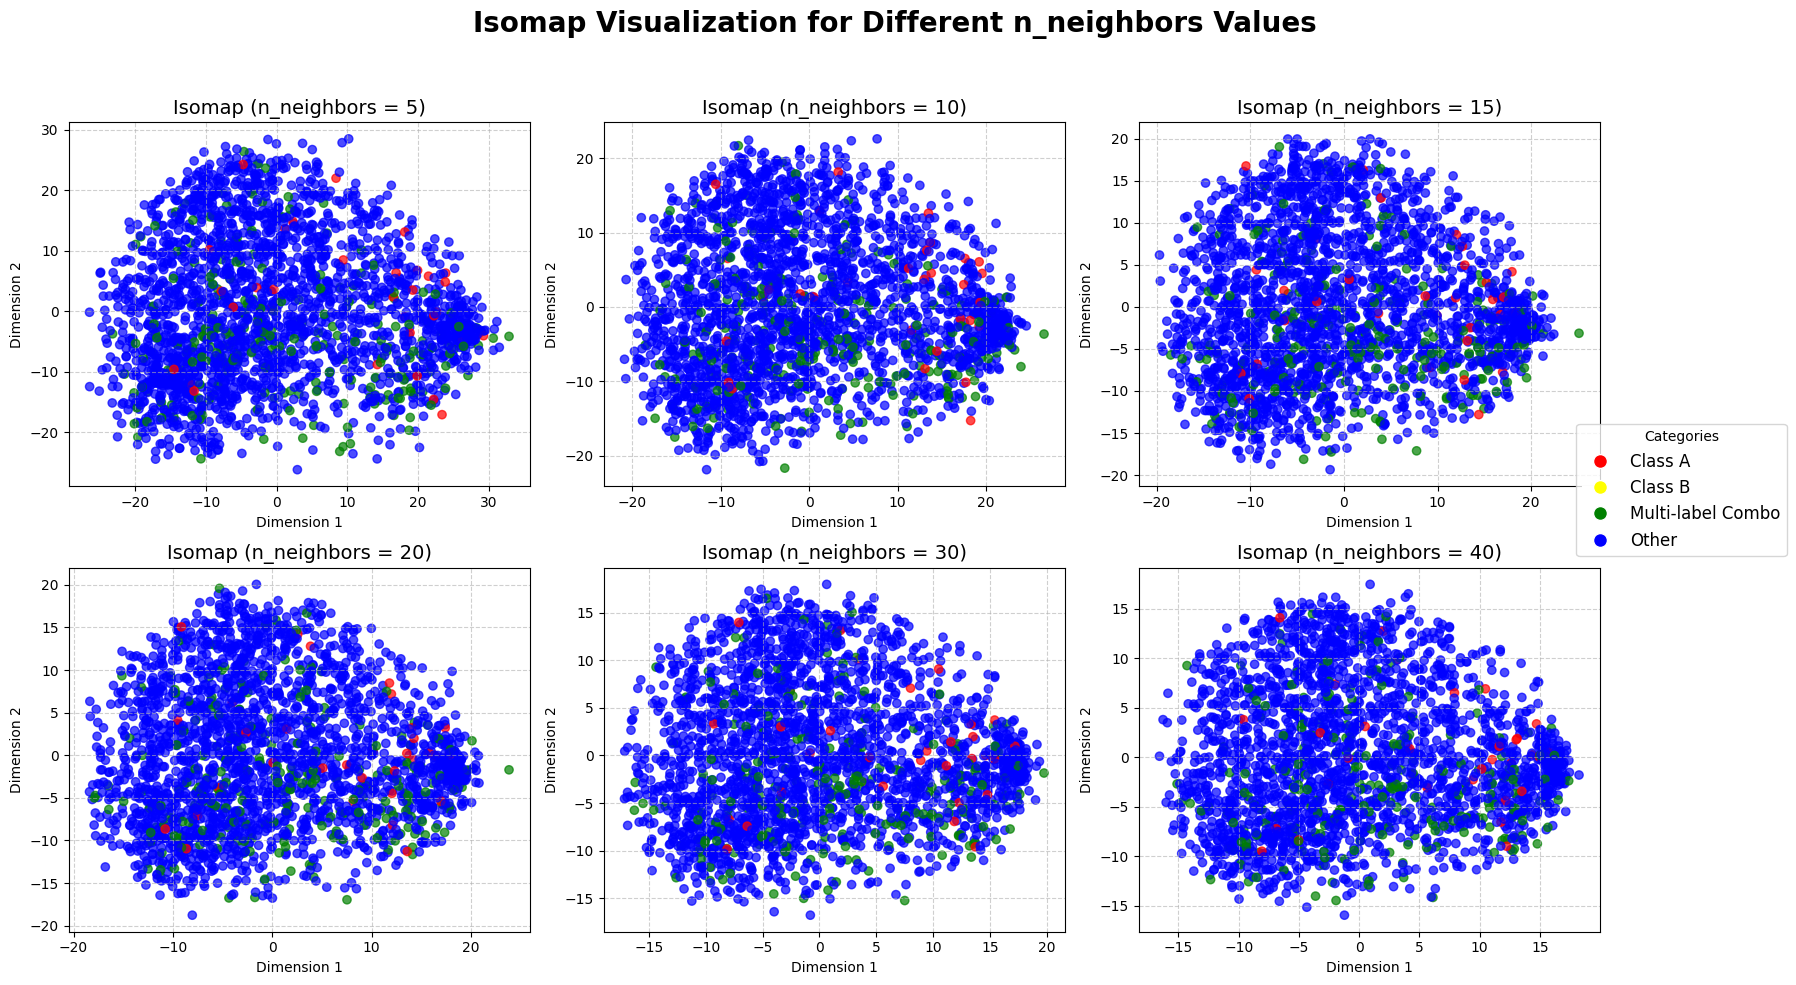

In [ ]:
color_map = {"Class A": "red", "Class B": "yellow", "Multi-label Combo": "green", "Other": "blue"}
category_series = pd.Categorical(categories, categories=list(color_map.keys()))
colors = category_series.map(color_map)

neighbors_to_test = [5, 10, 15, 20, 30, 40]
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, n in enumerate(neighbors_to_test):
    ax = axes[i]
    
    isomap = Isomap(n_components=2, n_neighbors=n)
    X_isomap = isomap.fit_transform(X_scaled)

    ax.scatter(X_isomap[:, 0], X_isomap[:, 1], c=colors, alpha=0.7)
    ax.set_title(f"Isomap (n_neighbors = {n})", fontsize=14)
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    ax.grid(True, linestyle='--', alpha=0.6)

handles = [mlines.Line2D([0], [0], marker='o', color='w', label=label,
                         markerfacecolor=color, markersize=10)
           for label, color in color_map.items()]
fig.legend(handles=handles, title="Categories", loc="center right", bbox_to_anchor=(1.0, 0.5), fontsize=12)
fig.suptitle("Isomap Visualization for Different n_neighbors Values", fontsize=20, weight='bold')
plt.tight_layout(rect=[0, 0, 0.9, 0.95]) 
plt.show()

#### Visual Analysis

| n_neighbors| Observation from Visual Plots                            | Interpretation & Alignment with Elbow Plot                                                                 |
| :------------------ | :------------------------------------------------------- | :--------------------------------------------------------------------------------------------------------- |
| **5 - 10**          | Chaotic, stretched, and fragmented structure.            | **Too Low.** The plot is unstable, confirming the neighborhood graph is disconnected, leading to high reconstruction error. |
| **15 - 20**         | The structure becomes coherent and forms a stable shape. | **Stabilizing.** The graph is now connected. `n=20` is the beginning of the "elbow" region and a very good choice. |
| **30**              | **Clear, stable, well-defined circular structure.**      | **Optimal.** Corresponds perfectly to the "elbow." It's the best balance of connecting the manifold without distortion. |
| **40+**             | Visually identical to `n=30`, slightly more compact.      | **Past the Elbow.** No new information is gained. The simpler model (`n=30`) is preferred to avoid potential short-circuits. |

Therefore, based on a combined analysis of the reconstruction error "elbow" plot and the visual inspection of the embeddings, the optimal choice for `n_neighbors` is **30**.

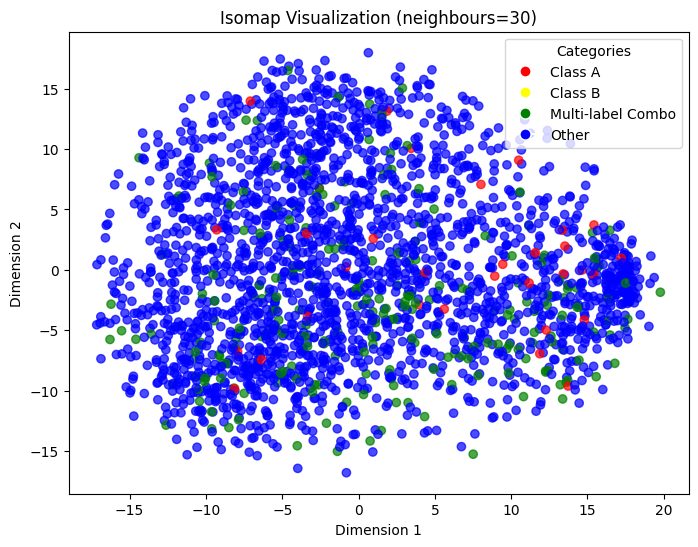

In [ ]:
best_n = 30
color_map = {"Class A": "red", "Class B": "yellow", "Multi-label Combo": "green", "Other": "blue"}
category_series = pd.Categorical(categories, categories=list(color_map.keys()))
colors = category_series.map(color_map)

isomap = Isomap(n_components=2, n_neighbors=best_n)
X_isomap = isomap.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_isomap[:,0], X_isomap[:,1], c=colors, alpha=0.7)
handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=8)
           for label, color in color_map.items()]
plt.legend(handles=handles, title="Categories", loc="best")

plt.title("Isomap Visualization")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title(f"Isomap Visualization (neighbours={best_n})")
plt.show()

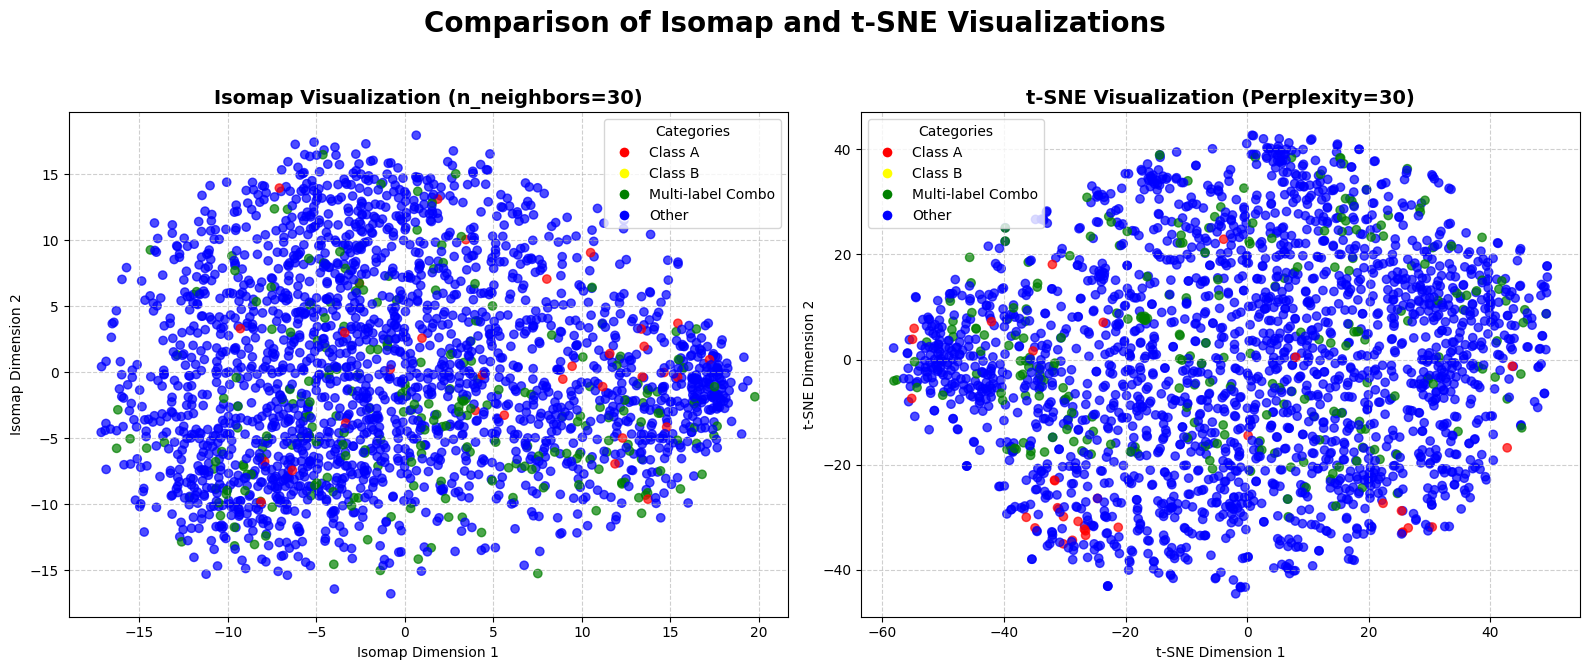

In [21]:
best_p = 30  # Best perplexity for t-SNE
best_n = 30  # Best n_neighbors for Isomap

color_map = {"Class A": "red", "Class B": "yellow", "Multi-label Combo": "green", "Other": "blue"}
category_series = pd.Categorical(categories, categories=list(color_map.keys()))
colors = category_series.map(color_map)

handles = [mlines.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=8)
           for label, color in color_map.items()]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: Isomap Visualization  
isomap = Isomap(n_components=2, n_neighbors=best_n)
X_isomap = isomap.fit_transform(X_scaled)

ax1.scatter(X_isomap[:, 0], X_isomap[:, 1], c=colors, alpha=0.7)
ax1.legend(handles=handles, title="Categories", loc="best")
ax1.set_title(f"Isomap Visualization (n_neighbors={best_n})", fontsize=14, weight='bold')
ax1.set_xlabel("Isomap Dimension 1")
ax1.set_ylabel("Isomap Dimension 2")
ax1.grid(True, linestyle='--', alpha=0.6)

# Plot 2: t-SNE Visualization
tsne_final = TSNE(n_components=2, perplexity=best_p, random_state=random_seed)
X_tsne_final = tsne_final.fit_transform(X_scaled)

ax2.scatter(X_tsne_final[:, 0], X_tsne_final[:, 1], c=colors, alpha=0.7)
ax2.legend(handles=handles, title="Categories", loc="best")
ax2.set_title(f"t-SNE Visualization (Perplexity={best_p})", fontsize=14, weight='bold')
ax2.set_xlabel("t-SNE Dimension 1")
ax2.set_ylabel("t-SNE Dimension 2")
ax2.grid(True, linestyle='--', alpha=0.6)

fig.suptitle("Comparison of Isomap and t-SNE Visualizations", fontsize=20, weight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Final Comparison: Isomap vs. t-SNE

This analysis compares the final Isomap visualization (`n_neighbors=30`) with the final t-SNE visualization (`perplexity=30`) to understand the structure of the data.

#### Isomap vs. t-SNE: Global Structure Visualization

**Isomap is unequivocally better at revealing the global structure of the data, while t-SNE is superior for identifying local cluster structures.**

*   **Isomap's Finding (Global View):**
    The Isomap plot displays the data as a single, large, and relatively dense cloud. This is the key insight into the global structure: the data manifold is **one contiguous piece**. There are no distinct, far-separated continents of data. The distances in the Isomap plot are meaningful; points on opposite sides of the cloud are truly far apart along the intrinsic geometry of the data. However, Isomap does a poor job of separating the classes; `Class A` (red) and `Multi-label Combo` (green) points are distributed throughout the `Other` (blue) points with no clear separation.

*   **t-SNE's Finding (Local View):**
    The t-SNE plot, by contrast, excels at showing local relationships. It successfully pulls similar points together into tight, visually distinct clusters. We can clearly see a dense cluster of `Class A` points in the lower-left, as well as other smaller groupings. t-SNE achieves this by sacrificing the preservation of true global distances. The vast empty space between clusters in the t-SNE plot is an artifact created to emphasize cluster separation and is **not representative** of the true global distance.

**Conclusion:** Isomap's single-cloud result *is* the depiction of the global structure. t-SNE breaks this global view to provide a magnified look at the local neighborhood similarities, making it better for identifying potential clusters.

#### The Data Manifold and Classification Difficulty

*   **Concept of the Data Manifold:**
    The "data manifold" is the intrinsic, lower-dimensional surface on which the high-dimensional data points are thought to lie. For example, a rolled-up piece of paper is a 2D manifold existing in 3D space. Manifold learning algorithms like Isomap aim to "unroll" this surface to reveal its true shape.

*   **Interpreting Manifold Complexity from Isomap:**
    The Isomap plot suggests that the data manifold is **geometrically simple and has low curvature.** A complex, highly curved manifold would have resulted in an "unrolled" shape, such as a long strip (from a Swiss Roll) or branching arms. Instead, we see a roughly spherical cloud, which implies that the data in its high-dimensional space already exists in a single, ball-like shape without complex folds.

*   **Relation to Classification Difficulty:**
    A simple manifold does **not** guarantee an easy classification problem. The difficulty depends on how the class labels are distributed *on* the manifold.

    In this case, both visualizations show that the different classes are **highly intermingled and overlapping** on this simple manifold. There is no clean separation between `Class A`, `Multi-label Combo`, and `Other`. This means that the **decision boundary** required to separate these classes is highly complex and non-linear.

    **Therefore, the classification task is difficult not because the manifold has a complex shape, but because the classes are thoroughly mixed within that simple shape.** A simple linear classifier would fail because it cannot draw a straight line or plane to effectively separate the points. This is consistent with the "Hard-to-Learn" region we identified in the t-SNE plot, where multiple colors are completely interspersed.